In [2]:
import scipy.io
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from basic_layers import IBPLinear
from logger import Logger
from data import mnist_loaders, cifar_loaders, mnist_transform, cifar_transform
import Inference_Models
import trainNEMON
from ibp_loss import *

import foolbox as fb

In [141]:
# Generate empirical accuracy data for NEMON

for q in range(5):

    ibp_model = trainNEMON.NEMON_MM_Net(in_dim=784, out_dim=100, m=0.0)
    if q == 0:
        ibp_model.load_state_dict(torch.load('nemon_nonrobust5.pt',map_location=torch.device('cpu')))
    elif q == 1:
        ibp_model.load_state_dict(torch.load('nemon_robust2.pt',map_location=torch.device('cpu')))
    elif q == 2:
        ibp_model.load_state_dict(torch.load('nemon_robust3.pt',map_location=torch.device('cpu')))
    elif q == 3:
        ibp_model.load_state_dict(torch.load('nemon_robust4.pt',map_location=torch.device('cpu')))
    elif q == 4:
        ibp_model.load_state_dict(torch.load('nemon_robust5.pt',map_location=torch.device('cpu')))
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = Inference_Models.NEMON(in_dim=784, out_dim=100, m=0.0)

    model.nemon.linear_module.U.weight = ibp_model.nemon.linear_module.U.M.weight
    model.nemon.linear_module.U.bias = ibp_model.nemon.linear_module.U.M.bias
    model.nemon.linear_module.M.weight = ibp_model.nemon.linear_module.M.weight
    model.nemon.linear_module.eta = ibp_model.nemon.linear_module.eta
    model.nemon.linear_module.a = ibp_model.nemon.linear_module.a

    model.Wout.weight = ibp_model.Wout.weight
    model.Wout.bias = ibp_model.Wout.bias

    loss_fn = F.cross_entropy
    model.to(device)

    bounds = (-0.424212917883804, 2.82148653034729)

    fmodel = fb.PyTorchModel(model, bounds=bounds)

    trainLoader, testLoader = mnist_loaders(train_batch_size=100, test_batch_size=1000)

    acc_list = np.zeros(31)

    attack = fb.attacks.LinfProjectedGradientDescentAttack()
    for i in range(31):
        robust_accuracy = 0
        for j, batch in enumerate(testLoader):
          images, labels = batch[0].to(device), batch[1].to(device)
          if i == 0:
            epsilon = 0
            accuracy = fb.utils.accuracy(fmodel, images, labels)
            robust_accuracy += accuracy * len(labels)
          else:
            epsilon = i*0.01/0.3081
            raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilon)
            is_adv = is_adv.type(torch.FloatTensor)
            ra = 1 - is_adv.mean(axis=-1).numpy()
            ra = ra * len(labels)
            robust_accuracy += ra
        acc_list[i] = robust_accuracy/10000
        print(acc_list[i])
        if acc_list[i] == 0:
            break
    print(acc_list)
    
    if q == 0:
        np.save("NEMON_NonRobust_Empirical_PGD5", acc_list)
    elif q == 1:
        np.save("NEMON_Empirical_PGD2", acc_list)
    elif q == 2:
        np.save("NEMON_Empirical_PGD3", acc_list)
    elif q == 3:
        np.save("NEMON_Empirical_PGD4", acc_list)
    elif q == 4:
        np.save("NEMON_Empirical_PGD5", acc_list)

C:\Anaconda\lib\site-packages\foolbox\models\pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
C:\Anaconda\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9769999980926514
0.9572000000625849
0.9138999994844198
0.8256999984383583
0.689800001680851
0.5368000000715256
0.4032000005245209
0.2828999996185303
0.18949999809265136
0.12200000286102294
0.07759999632835388
0.049999988079071044
0.02919999957084656
0.018700003623962402
0.01260000467300415
0.007099992036819458
0.0042999863624572756
0.0015999972820281982
0.0008000016212463378
0.0002999961376190186
0.0001999974250793457
0.0
[9.76999998e-01 9.57200000e-01 9.13899999e-01 8.25699998e-01
 6.89800002e-01 5.36800000e-01 4.03200001e-01 2.82900000e-01
 1.89499998e-01 1.22000003e-01 7.75999963e-02 4.99999881e-02
 2.91999996e-02 1.87000036e-02 1.26000047e-02 7.09999204e-03
 4.29998636e-03 1.59999728e-03 8.00001621e-04 2.99996138e-04
 1.99997425e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


C:\Anaconda\lib\site-packages\foolbox\models\pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
C:\Anaconda\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9574999988079071
0.9512999998405576
0.9458000006154179
0.9385999996215105
0.9311000000685453
0.9214999999850988
0.9126000002026557
0.9002999998629093
0.8879999995231629
0.8744000006467104
0.8591000009328127
0.8412000007927418
0.8183999992907047
0.7936000004410744
0.756900005042553
0.7098000004887581
0.6525999963283539
0.5889000028371811
0.5214000016450882
0.45540000796318053
0.39290000796318053
0.3319999992847443
0.2768000066280365
0.22530000805854797
0.17870000004768372
0.14890000224113464
0.11880000233650208
0.0981999933719635
0.08249999880790711
0.06890000104904175
0.06050000786781311
[0.9575     0.9513     0.9458     0.9386     0.9311     0.9215
 0.9126     0.9003     0.888      0.8744     0.8591     0.8412
 0.8184     0.7936     0.75690001 0.7098     0.6526     0.5889
 0.5214     0.45540001 0.39290001 0.332      0.27680001 0.22530001
 0.1787     0.1489     0.1188     0.09819999 0.0825     0.0689
 0.06050001]


C:\Anaconda\lib\site-packages\foolbox\models\pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
C:\Anaconda\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.949400007724762
0.9429999997839331
0.9363000003620983
0.9294999994337558
0.9203999999910593
0.9112000003457069
0.9013999991118908
0.8898999981582165
0.8766000010073185
0.8621999979019165
0.8465999998152256
0.8278000004589557
0.8064999975264072
0.7825000010430813
0.7529000014066696
0.712100000679493
0.6641000002622605
0.6064999967813491
0.541799995303154
0.4842999964952469
0.42100000083446504
0.36540000438690184
0.3088000059127808
0.2543999969959259
0.20649998784065246
0.16430000066757203
0.1321000039577484
0.10399999618530273
0.08109999895095825
0.0637000024318695
0.048900002241134645
[0.94940001 0.943      0.9363     0.9295     0.9204     0.9112
 0.9014     0.8899     0.8766     0.8622     0.8466     0.8278
 0.8065     0.7825     0.7529     0.7121     0.6641     0.6065
 0.5418     0.4843     0.421      0.3654     0.30880001 0.2544
 0.20649999 0.1643     0.1321     0.104      0.0811     0.0637
 0.0489    ]


C:\Anaconda\lib\site-packages\foolbox\models\pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
C:\Anaconda\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9553000032901764
0.9499999992549419
0.9442999996244907
0.9361999999731779
0.9266000002622604
0.9183999989181757
0.9084999989718199
0.8972000002861023
0.8847999997437
0.8707999996840954
0.8563000004738569
0.8356999978423119
0.8090000011026859
0.7763999983668327
0.7332999974489212
0.6859999999403954
0.6331000000238418
0.5692000031471253
0.5129000008106231
0.4534000039100647
0.3927999913692474
0.33309999108314514
0.28669999837875365
0.24309999942779542
0.2031000018119812
0.17179999947547914
0.14140000343322753
0.11500000357627868
0.09150000810623168
0.07409999966621399
0.05999999046325684
[0.9553     0.95       0.9443     0.9362     0.9266     0.9184
 0.9085     0.8972     0.8848     0.8708     0.8563     0.8357
 0.809      0.7764     0.7333     0.686      0.6331     0.5692
 0.5129     0.4534     0.39279999 0.33309999 0.2867     0.2431
 0.2031     0.1718     0.1414     0.115      0.09150001 0.0741
 0.05999999]


C:\Anaconda\lib\site-packages\foolbox\models\pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
C:\Anaconda\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9540999889373779
0.9491999989375473
0.9430000001564622
0.9368999987840653
0.9290999993681908
0.9214999997988343
0.9111999984830618
0.9005999997258186
0.891500000283122
0.8781999994069338
0.8657999996095895
0.8487000003457069
0.8302000001072883
0.8050999991595745
0.7776000022888183
0.7435999974608422
0.7007000043988227
0.6500000014901162
0.5899999976158142
0.5300000011920929
0.4705000013113022
0.40639999508857727
0.34600000381469725
0.28920000195503237
0.24119999408721923
0.19600000381469726
0.15959999561309815
0.12520000338554382
0.09989999532699585
0.0796999990940094
0.06290000081062316
[0.95409999 0.9492     0.943      0.9369     0.9291     0.9215
 0.9112     0.9006     0.8915     0.8782     0.8658     0.8487
 0.8302     0.8051     0.7776     0.7436     0.7007     0.65
 0.59       0.53       0.4705     0.4064     0.346      0.2892
 0.24119999 0.196      0.1596     0.1252     0.0999     0.0797
 0.0629    ]


In [134]:
# Generate empirical accuracy for feedforward model

ibp_model = trainNEMON.FeedForwardNN(in_dim=784, out_dim=25)
ibp_model.load_state_dict(torch.load('ff_robust5.pt',map_location=torch.device('cpu')))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Inference_Models.FFInference(in_dim=784, out_dim=25)

model.W1.weight = ibp_model.W1.M.weight
model.W1.bias = ibp_model.W1.M.bias
model.W2.weight = ibp_model.W2.M.weight
model.W2.bias = ibp_model.W2.M.bias
model.W3.weight = ibp_model.W3.M.weight
model.W3.bias = ibp_model.W3.M.bias
model.W4.weight = ibp_model.W4.M.weight
model.W4.bias = ibp_model.W4.M.bias
model.W5.weight = ibp_model.W5.M.weight
model.W5.bias = ibp_model.W5.M.bias
model.Wout.weight = ibp_model.Wout.weight
model.Wout.bias = ibp_model.Wout.bias


loss_fn = F.cross_entropy
model.to(device)

bounds = (-0.424212917883804, 2.82148653034729)

fmodel = fb.PyTorchModel(model, bounds=bounds)

trainLoader, testLoader = mnist_loaders(train_batch_size=100, test_batch_size=1000)

acc_list = np.zeros(31)

attack = fb.attacks.LinfProjectedGradientDescentAttack()
for i in range(31):
    robust_accuracy = 0
    for j, batch in enumerate(testLoader):
      images, labels = batch[0].to(device), batch[1].to(device)
      if i == 0:
        epsilon = 0
        accuracy = fb.utils.accuracy(fmodel, images, labels)
        robust_accuracy += accuracy * len(labels)
      else:
        epsilon = i*0.01/0.3081
        raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilon)
        is_adv = is_adv.type(torch.FloatTensor)
        ra = 1 - is_adv.mean(axis=-1).numpy()
        ra = ra * len(labels)
        robust_accuracy += ra
    acc_list[i] = robust_accuracy/10000
    print(acc_list[i])
    if acc_list[i] == 0:
        break
print(acc_list)
np.save("FF_Empirical_PGD5", acc_list)

C:\Anaconda\lib\site-packages\foolbox\models\pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


0.9300000071525574
0.9234000004827976
0.9163999997079373
0.908500000834465
0.8993999999016523
0.8893999993801117
0.8805000022053718
0.8713000006973743
0.8614000007510185
0.8494999997317791
0.8377999983727932
0.8231999978423119
0.8061999984085559
0.7816999986767769
0.7473000034689903
0.7046999976038932
0.6516000032424927
0.5931999951601028
0.527199998497963
0.45519999861717225
0.38219999670982363
0.3105000019073486
0.25029999017715454
0.20780000686645508
0.17050000429153442
0.13999999165534974
0.11070000529289245
0.08799999952316284
0.0703000009059906
0.057599997520446776
0.04390000700950623
[0.93000001 0.9234     0.9164     0.9085     0.8994     0.8894
 0.8805     0.8713     0.8614     0.8495     0.8378     0.8232
 0.8062     0.7817     0.7473     0.7047     0.6516     0.5932
 0.5272     0.4552     0.3822     0.3105     0.25029999 0.20780001
 0.1705     0.13999999 0.11070001 0.088      0.0703     0.0576
 0.04390001]


In [4]:
## Compute means and standard deviations
# Feedforward trained with IBP:
ffnn1=np.load("FF_Empirical_PGD.npy")
ffnn2=np.load("FF_Empirical_PGD2.npy")
ffnn3=np.load("FF_Empirical_PGD3.npy")
ffnn4=np.load("FF_Empirical_PGD4.npy")
ffnn5=np.load("FF_Empirical_PGD5.npy")
# stack vertically
ffnn = np.vstack((ffnn1,ffnn2,ffnn3,ffnn4,ffnn5))
ffnn_mean = np.mean(ffnn, axis=0)
ffnn_std = np.std(ffnn, axis=0)
#print(ffnn_mean)
#print(ffnn_std)

# NEMON trained with MM:
nemon1=np.load("NEMON_Empirical_PGD.npy")
nemon2=np.load("NEMON_Empirical_PGD2.npy")
nemon3=np.load("NEMON_Empirical_PGD3.npy")
nemon4=np.load("NEMON_Empirical_PGD4.npy")
nemon5=np.load("NEMON_Empirical_PGD5.npy")
# stack vertically
nemon = np.vstack((nemon1,nemon2,nemon3,nemon4,nemon5))
nemon_mean = np.mean(nemon, axis=0)
nemon_std = np.std(nemon, axis=0)
#print(nemon_mean)
#print(nemon_std)

# Feedforward not robustly trained
ffnnR1=np.load("FF_NonRobust_Empirical_PGD.npy")
ffnnR2=np.load("FF_NonRobust_Empirical_PGD2.npy")
ffnnR3=np.load("FF_NonRobust_Empirical_PGD3.npy")
ffnnR4=np.load("FF_NonRobust_Empirical_PGD4.npy")
ffnnR5=np.load("FF_NonRobust_Empirical_PGD5.npy")
# stack vertically
ffnnR = np.vstack((ffnnR1,ffnnR2,ffnnR3,ffnnR4,ffnnR5))
ffnnR_mean = np.mean(ffnnR, axis=0)
ffnnR_std = np.std(ffnnR, axis=0)
#print(ffnnR_mean)
#print(ffnnR_std)

# NEMON not robustly trained
nemonR1=np.load("NEMON_NonRobust_Empirical_PGD.npy")
nemonR2=np.load("NEMON_NonRobust_Empirical_PGD2.npy")
nemonR3=np.load("NEMON_NonRobust_Empirical_PGD3.npy")
nemonR4=np.load("NEMON_NonRobust_Empirical_PGD4.npy")
nemonR5=np.load("NEMON_NonRobust_Empirical_PGD5.npy")
# stack vertically
nemonR = np.vstack((nemonR1,nemonR2,nemonR3,nemonR4,nemonR5))
nemonR_mean = np.mean(nemonR, axis=0)
nemonR_std = np.std(nemonR, axis=0)
print(nemonR_mean)
print(nemonR_std)

[9.77319996e-01 9.55920000e-01 9.14860000e-01 8.35680000e-01
 7.07260001e-01 5.47459999e-01 4.02400005e-01 2.82720001e-01
 1.91159999e-01 1.24620000e-01 8.03600013e-02 5.14999986e-02
 3.18200016e-02 1.98800027e-02 1.29200053e-02 7.60000229e-03
 4.61999536e-03 2.45999813e-03 1.37999535e-03 7.79995918e-04
 4.59997654e-04 1.79997683e-04 1.19998455e-04 3.99994850e-05
 3.99994850e-05 1.99997425e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[1.60424672e-03 1.70105817e-03 1.36762550e-03 8.21642296e-03
 1.70991928e-02 1.41896603e-02 1.05956612e-02 6.89446287e-03
 8.00264606e-03 5.64496407e-03 5.24389125e-03 4.13715245e-03
 3.33550333e-03 2.32671441e-03 1.36440264e-03 7.56306851e-04
 7.13866032e-04 6.52992917e-04 4.44522178e-04 3.65513850e-04
 3.32265413e-04 1.16617536e-04 1.16617536e-04 7.99989700e-05
 7.99989700e-05 3.99994850e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


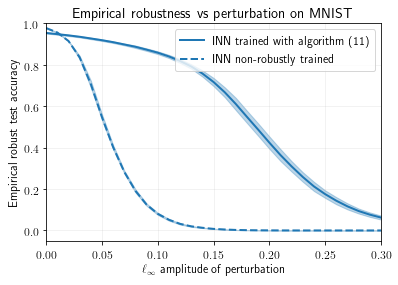

In [8]:
## Plot empirical accuracy

nemon=np.load("NEMON_Empirical_FGSM.npy")
ffnn=np.load("FF_Empirical_FGSM.npy")
nemonR = np.load("NEMON_NonRobust_Empirical_FGSM.npy")
ffnnR = np.load("FF_NonRobust_Empirical_FGSM.npy")

epsilons = np.linspace(0, 0.3, num=31)
plt.rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "cm"
plt.grid(alpha=0.2)

plt.rcParams.update({'font.size': 12})

plt.plot(epsilons, nemon_mean, label="INN trained with algorithm (11)", color='#1f77b4', linewidth=2)
plt.fill_between(epsilons, nemon_mean-1*nemon_std, nemon_mean+1*nemon_std, 
                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
#plt.plot(epsilons, ffnn_mean, label="FFNN w/ IBP", color='#1f77b4', linewidth=2)
#plt.fill_between(epsilons, ffnn_mean-1*ffnn_std, ffnn_mean+1*ffnn_std, 
#                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
plt.plot(epsilons, nemonR_mean, '--', label="INN non-robustly trained", color='#1f77b4', linewidth=2)
plt.fill_between(epsilons, nemonR_mean-1*nemonR_std, nemonR_mean+1*nemonR_std, 
                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
#plt.plot(epsilons, ffnnR_mean, '--', label="FFNN w/o IBP", color='#1f77b4', linewidth=2)
#plt.fill_between(epsilons, ffnnR_mean-1*ffnnR_std, ffnnR_mean+1*ffnnR_std, 
#                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
plt.xlabel(r'$\ell_{\infty}$ amplitude of perturbation')
plt.ylabel("Empirical robust test accuracy")
plt.title("Empirical robustness vs perturbation on MNIST")
plt.ylim(-0.05, 1.0)
plt.xlim(-0.0, 0.3)
#plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', fontsize=12, ncol=2)
plt.legend(loc='upper right', ncol=1)
plt.savefig("PGD_MNIST_withoutFFNN.pdf", bbox_inches='tight', dpi=300)

In [84]:
# Load FFNN model

ibp_model = trainNEMON.FeedForwardNN(in_dim=784, out_dim=25)
ibp_model.load_state_dict(torch.load('ff_robust5.pt',map_location=torch.device('cpu')))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainLoader, testLoader = mnist_loaders(train_batch_size=100, test_batch_size=1000)

scatter_mat = compute_sa(n_class=10)

epsilons = np.linspace(0, 0.3/0.3081, num=31)
ibp_acc = np.zeros_like(epsilons)

with torch.no_grad():
    for i in range(len(epsilons)):
        ibp_incorrect = 0
        for batch in testLoader:
            data, target = batch[0], batch[1]
            z = ibp_model(data,eps=epsilons[i])
            ibp_preds = compute_ibp_elide_z(ibp_model.Wout, z[1], z[2], target, scatter_mat, n_class=10)
            ibp_incorrect += ibp_preds.float().argmax(1).ne(target.data).sum()
        ibp_acc[i] = 1-(ibp_incorrect.detach().numpy())/10000
        print(ibp_acc[i])
        if ibp_acc[i] == 0.0:
            break
print(ibp_acc)
np.save("FF_Certified035", ibp_acc)

0.9299999999999999
0.922
0.9133
0.903
0.89
0.8788
0.8654
0.8515
0.8358
0.8153
0.7918000000000001
0.7637
0.7183999999999999
0.6383
0.498
0.32830000000000004
0.18720000000000003
0.09230000000000005
0.03920000000000001
0.016199999999999992
0.006199999999999983
0.0021999999999999797
0.0007000000000000339
0.0
[9.300e-01 9.220e-01 9.133e-01 9.030e-01 8.900e-01 8.788e-01 8.654e-01
 8.515e-01 8.358e-01 8.153e-01 7.918e-01 7.637e-01 7.184e-01 6.383e-01
 4.980e-01 3.283e-01 1.872e-01 9.230e-02 3.920e-02 1.620e-02 6.200e-03
 2.200e-03 7.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]


In [2]:
# Load NEMON model

ibp_model = trainNEMON.NEMON_MM_Net(in_dim=784, out_dim=100, m=0.0)
ibp_model.load_state_dict(torch.load('nemon_robust5.pt',map_location=torch.device('cpu')))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainLoader, testLoader = mnist_loaders(train_batch_size=100, test_batch_size=1000)

scatter_mat = compute_sa(n_class=10)

epsilons = np.linspace(0, 0.3/0.3081, num=31)
ibp_acc = np.zeros_like(epsilons)

with torch.no_grad():
    for i in range(len(epsilons)):
        ibp_incorrect = 0
        for batch in testLoader:
            data, target = batch[0], batch[1]
            z = ibp_model(data,eps=epsilons[i])
            ibp_preds = compute_ibp_elide_z(ibp_model.Wout, z[1], z[2], target, scatter_mat, n_class=10)
            ibp_incorrect += ibp_preds.float().argmax(1).ne(target.data).sum()
        ibp_acc[i] = 1-(ibp_incorrect.detach().numpy())/10000
        print(ibp_acc[i])
        if ibp_acc[i] == 0.0:
            break
print(ibp_acc)        
np.save("NEMON_Certified035", ibp_acc)

0.9542
0.9471


KeyboardInterrupt: 

In [9]:
## Compute means and standard deviations
# Feedforward trained with IBP:
ffnn1=np.load("FF_Certified.npy")
ffnn2=np.load("FF_Certified032.npy")
ffnn3=np.load("FF_Certified033.npy")
ffnn4=np.load("FF_Certified034.npy")
ffnn5=np.load("FF_Certified035.npy")
# stack vertically
ffnn = np.vstack((ffnn1,ffnn2,ffnn3,ffnn4,ffnn5))
ffnn_mean = np.mean(ffnn, axis=0)
ffnn_std = np.std(ffnn, axis=0)
print(ffnn_mean)
print(ffnn_std)

# NEMON trained with MM:
nemon1=np.load("NEMON_Certified.npy")
nemon2=np.load("NEMON_Certified032.npy")
nemon3=np.load("NEMON_Certified033.npy")
nemon4=np.load("NEMON_Certified034.npy")
nemon5=np.load("NEMON_Certified035.npy")
# stack vertically
nemon = np.vstack((nemon1,nemon2,nemon3,nemon4,nemon5))
nemon_mean = np.mean(nemon, axis=0)
nemon_std = np.std(nemon, axis=0)
#print(nemon_mean)
#print(nemon_std)

# Feedforward not robustly trained
ffnnR1=np.load("FF_NonRobust_Certified03.npy")
ffnnR2=np.load("FF_NonRobust_Certified032.npy")
ffnnR3=np.load("FF_NonRobust_Certified033.npy")
ffnnR4=np.load("FF_NonRobust_Certified034.npy")
ffnnR5=np.load("FF_NonRobust_Certified035.npy")
# stack vertically
ffnnR = np.vstack((ffnnR1,ffnnR2,ffnnR3,ffnnR4,ffnnR5))
ffnnR_mean = np.mean(ffnnR, axis=0)
ffnnR_std = np.std(ffnnR, axis=0)
#print(ffnnR_mean)

# NEMON not robustly trained
nemonR1=np.load("NEMON_NonRobust_Certified03.npy")
nemonR2=np.load("NEMON_NonRobust_Certified032.npy")
nemonR3=np.load("NEMON_NonRobust_Certified033.npy")
nemonR4=np.load("NEMON_NonRobust_Certified034.npy")
nemonR5=np.load("NEMON_NonRobust_Certified035.npy")
# stack vertically
nemonR = np.vstack((nemonR1,nemonR2,nemonR3,nemonR4,nemonR5))
nemonR_mean = np.mean(nemonR, axis=0)
nemonR_std = np.std(nemonR, axis=0)
#print(nemonR_mean)
#print(nemonR_std)

[9.2732e-01 9.1904e-01 9.1054e-01 9.0142e-01 8.9052e-01 8.7960e-01
 8.6652e-01 8.5242e-01 8.3576e-01 8.1576e-01 7.9258e-01 7.6398e-01
 7.1808e-01 6.3488e-01 4.9662e-01 3.4202e-01 2.1240e-01 1.1710e-01
 5.8260e-02 2.7620e-02 1.2020e-02 5.4000e-03 2.0400e-03 4.0000e-04
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00]
[0.00846673 0.00941012 0.00994155 0.00998987 0.01048454 0.01083236
 0.01074717 0.01091447 0.01145873 0.01101936 0.01163347 0.01204349
 0.01222594 0.01264396 0.01365846 0.0080938  0.01342013 0.01397655
 0.01082046 0.00629234 0.00316822 0.00188997 0.00079398 0.00038471
 0.         0.         0.         0.         0.         0.
 0.        ]


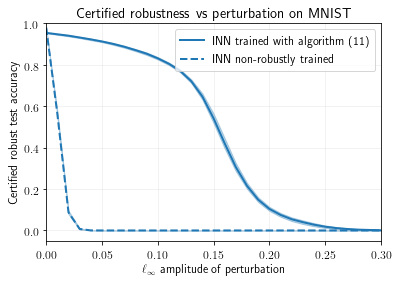

In [10]:
#nemon=np.load("NEMON_Certified.npy")
#ffnn=np.load("FF_Certified.npy")
#nemonR=np.load("NEMON_NonRobust_Certified03.npy")
#ffnnR=np.load("FF_NonRobust_Certified03.npy")

epsilons = np.linspace(0, 0.3, num=31)
plt.rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "cm"
plt.grid(alpha=0.2)

plt.rcParams.update({'font.size': 12})

plt.plot(epsilons, nemon_mean, label="INN trained with algorithm (11)", color='#1f77b4', linewidth=2)
plt.fill_between(epsilons, nemon_mean-1*nemon_std, nemon_mean+1*nemon_std, 
                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
#plt.plot(epsilons, ffnn_mean, label="FFNN w/ IBP", color='#1f77b4', linewidth=2)
#plt.fill_between(epsilons, ffnn_mean-1*ffnn_std, ffnn_mean+1*ffnn_std, 
#                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
plt.plot(epsilons, nemonR_mean, '--', label="INN non-robustly trained", color='#1f77b4', linewidth=2)
plt.fill_between(epsilons, nemonR_mean-1*nemonR_std, nemonR_mean+1*nemonR_std, 
                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
#plt.plot(epsilons, ffnnR_mean, '--', label="FFNN w/o IBP", color='#1f77b4', linewidth=2)
#plt.fill_between(epsilons, ffnnR_mean-1*ffnnR_std, ffnnR_mean+1*ffnnR_std, 
#                 alpha=0.3, edgecolor='#1f77b4', facecolor='#1f77b4')
plt.xlabel(r'$\ell_{\infty}$ amplitude of perturbation')
plt.ylabel("Certified robust test accuracy")
plt.title("Certified robustness vs perturbation on MNIST")
plt.ylim(-0.05, 1.0)
plt.xlim(-0.0, 0.3)
#plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', fontsize=12, ncol=2)
plt.legend(loc='upper right', ncol=1)
plt.savefig("Certified_MNIST_withoutFFNN.pdf", bbox_inches='tight', dpi=300)

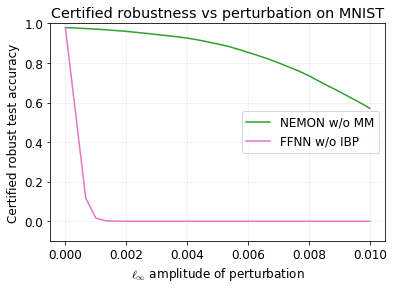

In [53]:
nemon=np.load("NEMON_NonRobust_Certified001.npy")
ffnn=np.load("FF_NonRobust_Certified.npy")

epsilons = np.linspace(0, 0.01, num=31)
plt.rcParams["mathtext.fontset"] = "cm"
plt.grid(alpha=0.2)

plt.rcParams.update({'font.size': 12})

plt.plot(epsilons, nemon, label="NEMON w/o MM", color='#2ca02c')
plt.plot(epsilons, ffnn, label="FFNN w/o IBP", color='#e377c2')
plt.xlabel(r'$\ell_{\infty}$ amplitude of perturbation')
plt.ylabel("Certified robust test accuracy")
plt.title("Certified robustness vs perturbation on MNIST")
plt.ylim(-0.099, 1.0)
#plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', fontsize=12, ncol=2)
plt.legend(loc='center right', ncol=1)
plt.savefig("Certified_NonRobust_MNIST.pdf", bbox_inches='tight', dpi=300)